In [ ]:
# This code is inspired by songgc's implementation in Tensorflow https://github.com/songgc/TF-recomm
# 

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import time
import sys
from collections import deque


Populating the interactive namespace from numpy and matplotlib


In [2]:
# movie ratings data
df = pd.read_csv('data/ratings.csv')
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0)

In [3]:
def random_batch(x, batch_size):
    ids = np.random.choice(x.index, size=batch_size)
    x = x.ix[ids]
    users = x['userId'].values
    users.resize(users.size, 1)

    items = x['movieId'].values
    items.resize(items.size, 1)

    features = x['rating'].values
    features.resize(features.size, 1)
    return users, items, features

def test_groups(x, batch_size):
    idx_group = np.array_split(np.arange(len(x)), np.ceil(len(x) / batch_size))
    iterator = iter(list(range(len(idx_group))))
    return iterator, idx_group

def test_batch(x, idx_group, group):
    x = x.reset_index().ix[idx_group[group], :]
    
    users = x['userId'].values
    users.resize(users.size, 1)

    items = x['movieId'].values
    items.resize(items.size, 1)

    features = x['rating'].values
    features.resize(features.size, 1)
    return users, items, features

def matrix_factorization(user_batch, item_batch, user_num, item_num, rank=5):
    bias_global = tf.get_variable("bias_global", shape=[])
    w_bias_user = tf.get_variable("embd_bias_user", shape=[user_num])
    w_bias_item = tf.get_variable("embd_bias_item", shape=[item_num])
    bias_user = tf.nn.embedding_lookup(w_bias_user, user_batch, name="bias_user")
    bias_item = tf.nn.embedding_lookup(w_bias_item, item_batch, name="bias_item")
    w_user = tf.get_variable("embd_user", shape=[user_num, rank],initializer=tf.truncated_normal_initializer(stddev=0.02))
    w_item = tf.get_variable("embd_worker", shape=[item_num, rank],initializer=tf.truncated_normal_initializer(stddev=0.02))
    embd_user = tf.nn.embedding_lookup(w_user, user_batch, name="embedding_user")
    embd_item = tf.nn.embedding_lookup(w_item, item_batch, name="embedding_item")
    mf = tf.reduce_sum(tf.multiply(embd_user, embd_item), 1)
    mf = tf.add(mf, bias_global)
    mf = tf.add(mf, bias_user)
    mf = tf.add(mf, bias_item, name="matrix_factorization")
    regularizer = tf.add(tf.nn.l2_loss(embd_user), tf.nn.l2_loss(embd_item), name="mf_regularizer")
    return mf, regularizer

def optimization(mf, regularizer, feature_batch, learning_rate, regularization):
    cost_l2 = tf.nn.l2_loss(tf.sub(mf, feature_batch))
    penalty = tf.constant(regularization, dtype=tf.float32, shape=[], name="l2")
    cost = tf.add(cost_l2, tf.multiply(regularizer, penalty))
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    return cost, train_op

In [4]:
batch_size = 1000

num_samples = df_train.shape[0] 

num_batches = int(num_samples / batch_size)

worker_num =  len(set(df_train['userId']))
item_num = len(set(df_train['movieId']))
rank= 10
learning_rate = 0.001
regularization = 0.05
last_loss = 0
early_stopping = 1e-6

epochs = 10000

user_batch = tf.placeholder(tf.int32, shape=[None, 1], name="id_company")
item_batch = tf.placeholder(tf.int32, shape=[None, 1], name="id_worker")
feature_batch = tf.placeholder(tf.float32, shape=[None, 1])

mf, regularizer = matrix_factorization(user_batch, item_batch, worker_num, item_num, rank)

cost, optimizer = optimization(mf, regularizer, feature_batch, learning_rate, regularization)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    errors = deque(maxlen=batch_size)
    
    losses = {'train':[], 'validation':[]}
    for i in range(epochs):
        batch_user, batch_item, batch_feature = random_batch(df_train, batch_size)
        
        _, pred_batch = sess.run([optimizer, mf], feed_dict={user_batch: batch_user,
                                                             item_batch: batch_item,
                                                             feature_batch: batch_feature})
            
        errors.append(np.power(pred_batch - batch_feature, 2))
        if i % num_batches == 0:
            train_err = np.sqrt(np.mean(errors))
            test_err2 = np.array([])
            iterator, idx_group = test_groups(df_test, batch_size)
            
            val_user, val_item, val_feature = test_batch(df_test, idx_group, iterator.next())
            
            pred_batch = sess.run(mf, feed_dict={user_batch: val_user,
                                                 item_batch: val_item})
                                                     
            test_err2 = np.append(test_err2, np.power(pred_batch - val_feature, 2))
            test_err = np.sqrt(np.mean(test_err2))
   
            
        sys.stdout.write("\rProgress: " + str(100 * i/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_err)[:7] \
                     + " ... Validation loss: " + str(test_err)[:7])
        losses['train'].append(train_err)
        losses['validation'].append(test_err)



Progress: 99.9% ... Training loss: 0.85493 ... Validation loss: 0.95769

(0.5, 4.0)

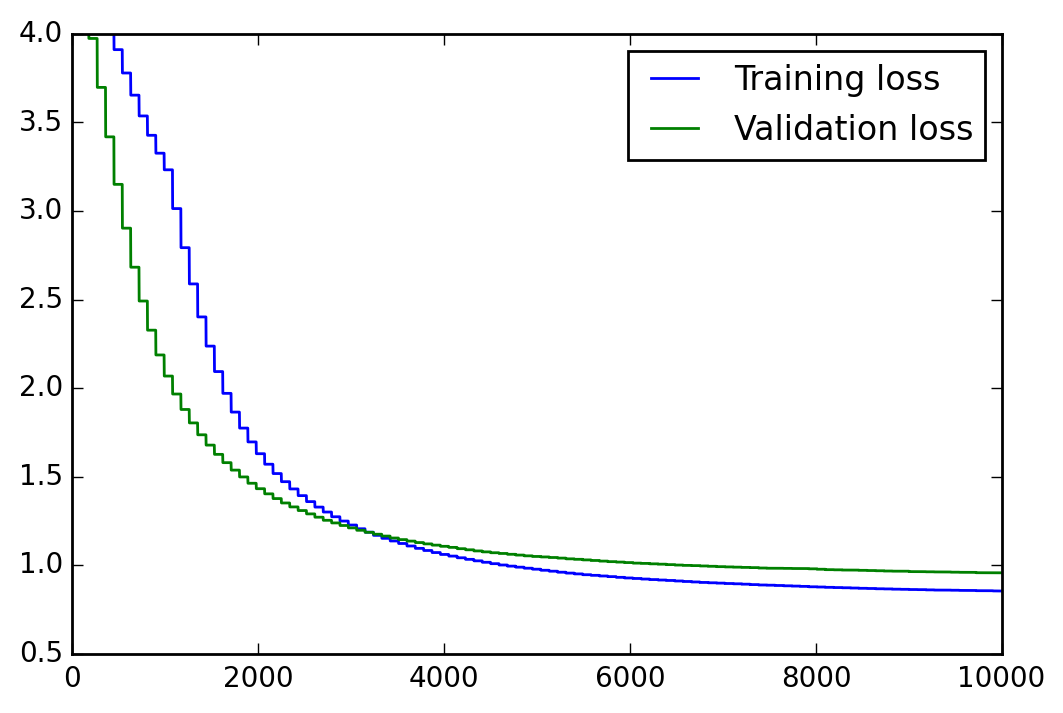

In [7]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=4.0)